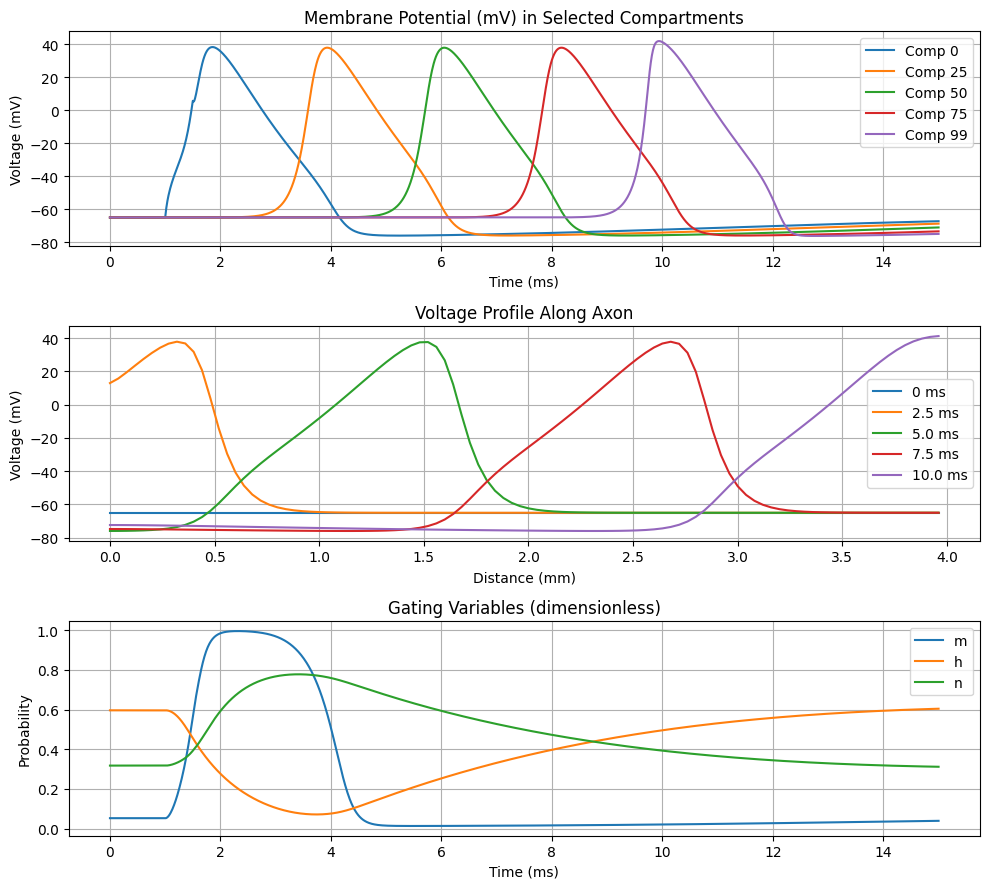

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hodgkin-Huxley Gating Variable Rate Functions

def alpha_m(V):
    """
    Activation "m" gate rate constant for Na+ channels.
    V : Membrane potential (mV)
    Returns alpha_m : Rate (ms^-1)
    """
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-0.1 * (V + 40.0)))


def beta_m(V):
    """
    Deactivation "m" gate rate constant for Na+ channels.
    V : Membrane potential (mV)
    Returns beta_m : Rate (ms^-1)
    """
    return 4.0 * np.exp(-(V + 65.0) / 18.0)


def alpha_h(V):
    """
    Activation "h" gate rate constant for Na+ channel inactivation.
    V : Membrane potential (mV)
    Returns alpha_h : Rate (ms^-1)
    """
    return 0.07 * np.exp(-(V + 65.0) / 20.0)


def beta_h(V):
    """
    Deactivation "h" gate rate constant (reopening) for Na+ channels.
    V : Membrane potential (mV)
    Returns beta_h : Rate (ms^-1)
    """
    return 1.0 / (1.0 + np.exp(-0.1 * (V + 35.0)))


def alpha_n(V):
    """
    Activation "n" gate rate constant for K+ channels.
    V : Membrane potential (mV)
    Returns alpha_n : Rate (ms^-1)
    """
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-0.1 * (V + 55.0)))


def beta_n(V):
    """
    Deactivation "n" gate rate constant for K+ channels.
    V : Membrane potential (mV)
    Returns beta_n : Rate (ms^-1)
    """
    return 0.125 * np.exp(-(V + 65.0) / 80.0)


def integrate_multicompartment(
    electrode_current_injector,
    num_compartments=100, 
    duration=15.0, # (ms)
    dt=0.01, # Time step (ms)
    comp_L=0.004, # Compartment length (cm)
    comp_a=1e-4, # Compartment radius (cm)
    cm=1.0, # Membrane capacitance (uF/cm^2)
    rL=100.0, # Axial resistivity (Ohm*cm)
    initial_voltages=None, # Initial membrane potentials (mV)
    gL=0.3, # Leak conductance (mS/cm^2)
    EL=-54.387, # Leak reversal potential (mV)
    gNa=120.0, # Max Na+ conductance (mS/cm^2)
    ENa=50.0, # Na+ reversal potential (mV)
    gK=36.0, # Max K+ conductance (mS/cm^2)
    EK=-77.0, # K+ reversal potential (mV)
    z=1.0 # Time-stepping parameter: 1.0=Backward Euler, 0.5=Crank-Nicolson
):
    # Set default initial voltages if not provided
    if initial_voltages is None:
        initial_voltages = np.full(num_compartments, -65.0)

    # Compartment geometry
    comp_surface_area = 2 * np.pi * comp_a * comp_L # Surface area (cm^2)
    comp_cross_section = np.pi * comp_a ** 2 # Cross-sectional area (cm^2)

    # Axial coupling conductance
    g_axial_coupling = comp_cross_section / (rL * comp_L) # Siemens (S)
    axial_conductance_per_area = (g_axial_coupling / comp_surface_area) * 1000.0 # mS/cm^2

    # Time discretization
    time_points = np.arange(0, duration + dt, dt) # ms
    num_time_steps = len(time_points)

    # Preallocate state arrays
    voltages = np.zeros((num_time_steps, num_compartments)) # mV
    m_states = np.zeros_like(voltages)
    h_states = np.zeros_like(voltages)
    n_states = np.zeros_like(voltages)

    # Initialize states
    voltages[0, :] = initial_voltages
    for i in range(num_compartments):
        V0 = initial_voltages[i]
        am, bm = alpha_m(V0), beta_m(V0)
        ah, bh = alpha_h(V0), beta_h(V0)
        an, bn = alpha_n(V0), beta_n(V0)
        m_states[0, i] = am / (am + bm)
        h_states[0, i] = ah / (ah + bh)
        n_states[0, i] = an / (an + bn)

    # Tridiagonal solver arrays
    alpha_t = np.zeros(num_compartments)
    beta_t  = np.zeros(num_compartments)
    gamma_t = np.zeros(num_compartments)
    rhs_t   = np.zeros(num_compartments)

    # Main time-stepping loop
    for t_idx in range(num_time_steps - 1):
        V = voltages[t_idx, :]
        m, h, n = m_states[t_idx, :], h_states[t_idx, :], n_states[t_idx, :]
        t = time_points[t_idx]

        # Update gating variables via exponential Euler
        m_next = np.zeros(num_compartments)
        h_next = np.zeros(num_compartments)
        n_next = np.zeros(num_compartments)

        for i in range(num_compartments):
            Vi = V[i]
            # m-gate
            am, bm = alpha_m(Vi), beta_m(Vi)
            tau_m = 1.0 / (am + bm)
            m_inf = am * tau_m
            m_next[i] = m_inf + (m[i] - m_inf) * np.exp(-dt / tau_m)

            # h-gate
            ah, bh = alpha_h(Vi), beta_h(Vi)
            tau_h = 1.0 / (ah + bh)
            h_inf = ah * tau_h
            h_next[i] = h_inf + (h[i] - h_inf) * np.exp(-dt / tau_h)

            # n-gate
            an, bn = alpha_n(Vi), beta_n(Vi)
            tau_n = 1.0 / (an + bn)
            n_inf = an * tau_n
            n_next[i] = n_inf + (n[i] - n_inf) * np.exp(-dt / tau_n)

        m_states[t_idx+1, :] = m_next
        h_states[t_idx+1, :] = h_next
        n_states[t_idx+1, :] = n_next

        # Conductances for each compartment (mS/cm^2)
        g_Na = gNa * (m_next**3) * h_next
        g_K  = gK * (n_next**4)

        # Build tridiagonal system
        for i in range(num_compartments):
            # Injected current
            I_e = electrode_current_injector(i, t)
            # Convert nA to uA/cm^2 current density
            Ie_uA_per_cm2 = (I_e * 1e-3) / comp_surface_area

            # Total membrane conductance
            g_mem = gL + g_Na[i] + g_K[i] # mS/cm^2
            I_rev = gL*EL + g_Na[i]*ENa + g_K[i]*EK # mS/cm^2 * mV = uA/cm^2

            # Axial terms
            A, C = 0.0, 0.0
            if i > 0:
                A = axial_conductance_per_area / cm # (mS/cm^2)/(uF/cm^2)
            if i < num_compartments-1:
                C = axial_conductance_per_area / cm
            g_ax_total = (0 if num_compartments==1 else (A+C)*cm)

            # Diagonal term B from membrane + axial
            B = -(g_mem + (A + C)*cm) / cm # ms^-1

            # Right-hand side accumulation
            rhs = (I_rev + Ie_uA_per_cm2) / cm # mV/ms

            # Thomas coefficients
            alpha_t[i] = -A * z * dt
            beta_t[i] = 1.0 - B * z * dt
            gamma_t[i] = -C * z * dt
            rhs_t[i] = rhs * dt + B*V[i]*dt + A*z*dt*(V[i-1] if i>0 else 0) + C*z*dt*(V[i+1] if i<num_compartments-1 else 0)

        cp = np.zeros(num_compartments)
        dp = np.zeros(num_compartments)
        dv = np.zeros(num_compartments)

        # Forward sweep
        cp[0] = gamma_t[0] / beta_t[0]
        dp[0] = rhs_t[0] / beta_t[0]
        for i in range(1, num_compartments):
            denom = beta_t[i] - alpha_t[i]*cp[i-1]
            cp[i] = gamma_t[i]/denom if i < num_compartments-1 else 0.0
            dp[i] = (rhs_t[i] - alpha_t[i]*dp[i-1]) / denom

        # Back substitution
        dv[-1] = dp[-1]
        for i in range(num_compartments-2, -1, -1):
            dv[i] = dp[i] - cp[i]*dv[i+1]

        # Update membrane potentials
        voltages[t_idx+1, :] = V + dv

    return time_points, voltages, m_states, h_states, n_states

def current_injector(comp_idx, t):
    if comp_idx == 0 and 1.0 <= t < 1.5:
        return 1.0  # nA pulse at compartment 0
    return 0.0

# Run simulation
time_ax, V_data, m_data, h_data, n_data = integrate_multicompartment(
    electrode_current_injector=current_injector,
    num_compartments=100,
    duration=15.0,
    dt=0.01,
    comp_L=0.004,
    comp_a=1e-4,
    cm=1.0,
    rL=100.0,
    gL=0.3,
    EL=-54.387,
    gNa=120.0,
    ENa=50.0,
    gK=36.0,
    EK=-77.0,
    z=1.0
)

# For plotting
num_compartments = 100
comp_L = 0.004 # cm

fig, axes = plt.subplots(3, 1, figsize=(10, 9))
compartments_to_plot = [0, 25, 50, 75, 99]
for comp in compartments_to_plot:
    axes[0].plot(time_ax, V_data[:, comp], label=f'Comp {comp}')
axes[0].set_title('Membrane Potential (mV) in Selected Compartments')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Voltage (mV)')
axes[0].legend()
axes[0].grid(True)

# Spatial voltage profile (distance in mm)
spatial_axis = np.arange(num_compartments) * comp_L * 10  # mm
snapshots = [0, 2.5, 5.0, 7.5, 10.0]  # ms
for t_snap in snapshots:
    idx = np.argmin(np.abs(time_ax - t_snap))
    axes[1].plot(spatial_axis, V_data[idx, :], label=f'{t_snap} ms')
axes[1].set_title('Voltage Profile Along Axon')
axes[1].set_xlabel('Distance (mm)')
axes[1].set_ylabel('Voltage (mV)')
axes[1].legend()
axes[1].grid(True)

# Gating variables for first compartment
axes[2].plot(time_ax, m_data[:, 0], label='m')
axes[2].plot(time_ax, h_data[:, 0], label='h')
axes[2].plot(time_ax, n_data[:, 0], label='n')
axes[2].set_title('Gating Variables (dimensionless)')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Probability')
axes[2].legend()
axes[2].grid(True)

fig.tight_layout()
fig.savefig('figures/multicompartment.svg', transparent=True, bbox_inches='tight')


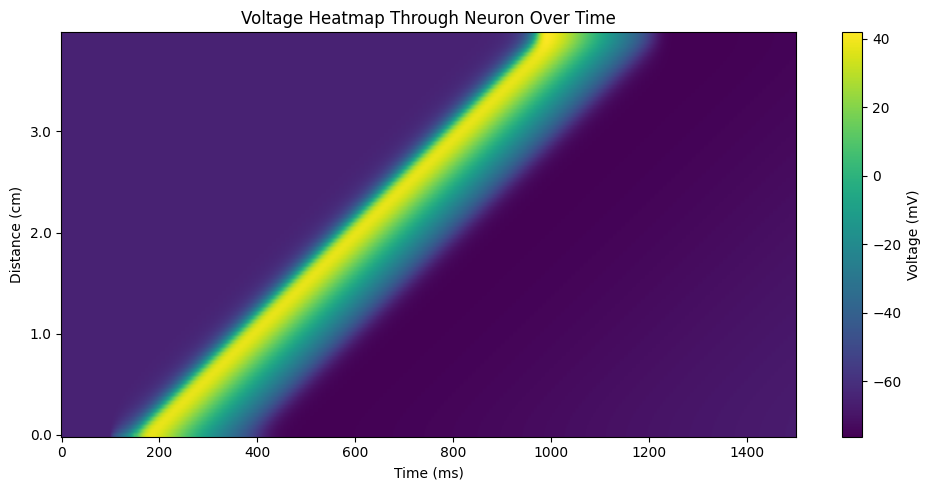

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.imshow(V_data.T, cmap='viridis', aspect='auto', origin='lower')
ax.set_title('Voltage Heatmap Through Neuron Over Time')
ax.set_xlabel('Time (ms)')
# ax.set_ylabel('Compartment Index')
ax.set_ylabel('Distance (cm)')
ax.set_yticks(np.linspace(0, num_compartments, 5), labels=[f'{i * comp_L * 10:.1f}' for i in np.linspace(0, num_compartments, 5)])
ax.grid(False)
fig.colorbar(ax.imshow(V_data.T, cmap='viridis', aspect='auto', origin='lower'), ax=ax, label='Voltage (mV)')

fig.tight_layout()
fig.savefig('figures/multicompartment_heatmap.svg', transparent=True, bbox_inches='tight')